In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics

from IPython.display import display
from io import StringIO

warnings.simplefilter('ignore')

##### Load datasets

Nos passos abaixo foram aplicados os seguintes tratamentos:

    Datasets carregados, um de logs das intencoes e textos e outro com titulos de filmes com a intencão 003_PROGRAMA
    Excluida as colunas que não serão utilizadas
    Merge dos datasets
    Dados ausentes (NaN) eliminados
    Retirado numeros e caracteres especiais
    Substituido 'TOKEN SHOW MORE' por Filmes de ação

In [20]:
dataset = pd.read_csv('Intents(17.01).csv')
movies_df = pd.read_csv('movies_df.csv')

In [21]:
dataset.shape

(2756, 3)

In [22]:
cols = ['texto',' intencao']
dataset = dataset[cols]
dataset.columns = ['texto','intencao']

In [23]:
dataset = dataset.append(movies_df)

In [24]:
dataset.dropna(inplace=True)

In [25]:
dataset.isna().sum()

texto       0
intencao    0
dtype: int64

In [26]:
#dataset['texto'] = dataset['texto'].str.replace('\d+','')## Exclui numeros do texto (influência no controle remoto)
#dataset['texto'] = dataset['texto'].str.replace('TOKEN_SHOW_MORE','Filmes de ação')

In [27]:
dataset.sample(10)

,texto,intencao
23484,princesa do sertão,003_PROGRAMAS
24059,ava's possessions,003_PROGRAMAS
1535,como que eu faco pra colocar pra gravar a dist...,005_gravacao_pelo_app
26673,barbie super princesa,003_PROGRAMAS
24190,enrolados a série,003_PROGRAMAS
5602,kinderhandel mitten in europa,003_PROGRAMAS
947,love birds,003_PROGRAMAS
5827,cantorias,003_PROGRAMAS
22913,brasil da gente,003_PROGRAMAS
22457,de volta para o presente,003_PROGRAMAS


##### Gráfico de barras com a contagem das intencões.

In [ ]:
fig = plt.figure(figsize=(25,15))
dataset.groupby('intencao').texto.count().plot.bar(ylim=0)
plt.show()

##### Cria a coluna intencao_id com versão numérica das intencões.

In [28]:
#dataset['intencao'] = dataset['intencao'].astype('category')
dataset['intencao_id'] = dataset['intencao'].factorize()[0]

intencao_id_df = dataset[['intencao', 'intencao_id']].drop_duplicates().sort_values('intencao_id')
intencao_to_id = dict(intencao_id_df.values)
id_to_intencao = dict(intencao_id_df[['intencao_id', 'intencao']].values)

##### Vetorizando o dataset, separando features e labels.

In [29]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(dataset.texto).toarray()
labels = dataset.intencao
features.shape , labels.shape

((31507, 4489), (31507,))

##### Palavras associadas a cada intencão usando chi2.

In [ ]:
N = 2
for dataset['intencao'], dataset['intencao_id'] in sorted(intencao_to_id.items()):
  features_chi2 = chi2(features, labels == intencao_to_id.items)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(intencao_to_id.items))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

### Train and Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(dataset['texto'], dataset['intencao'], random_state = 10)

### Multiple Models

    Random Forest
    Support Vector Machines SVM
    Naive bayes Multinomial
    Regressão Logistica
    
Abaixo boxplot da acurácia de cada modelo

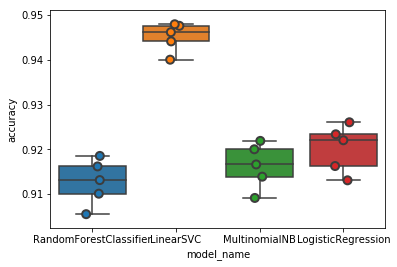

In [31]:
models = [
    RandomForestClassifier(n_estimators=400, max_depth=9, random_state=1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [32]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.945162
LogisticRegression        0.920168
MultinomialNB             0.916327
RandomForestClassifier    0.912709
Name: accuracy, dtype: float64

##### Matriz de confusão (Muito grande devido a quantidade de classes (visualização inviável)).

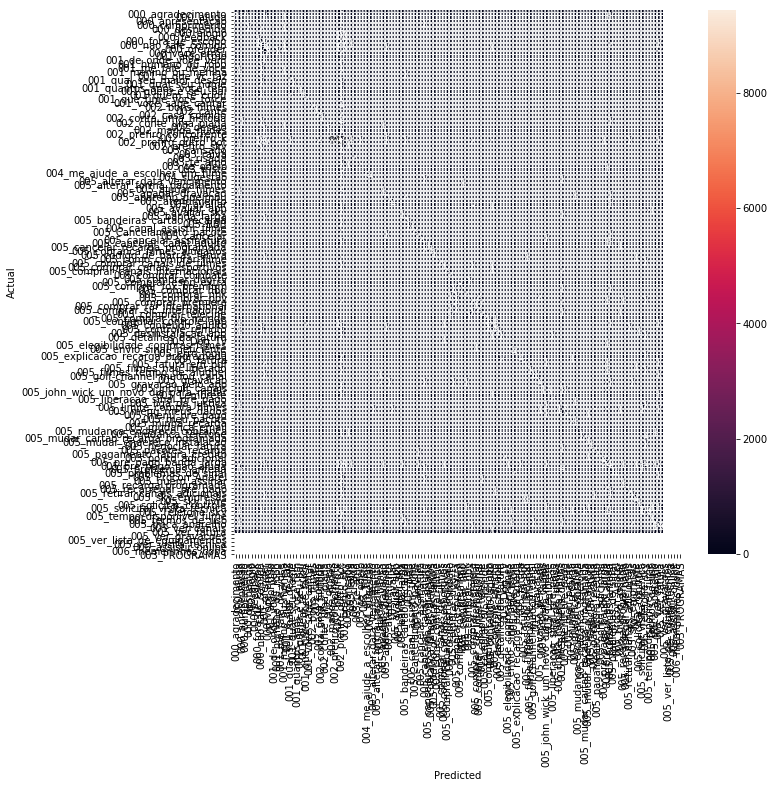

In [35]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataset.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=intencao_id_df.intencao.values, yticklabels=intencao_id_df.intencao.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in intencao_id_df.intencao_id:
  for actual in intencao_id_df.intencao_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_intencao[actual], id_to_intencao[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['intencao', 'texto']])
      print('')

### Test

In [ ]:
## Adicionar frases que causam confusão na detecção de intencão.
model = LinearSVC()
texts = ['']

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format([predicted]))
  print("")

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=dataset['intencao'].unique()))

#### Validação dados de janeiro

In [33]:
validacao = pd.read_csv('logs_validacao.csv')
validacao['texto'] = validacao['texto'].str.replace('\d+','')
validacao['texto'] = validacao['texto'].str.replace('...,-,..-, ,!,@,#,$,%,ˆ,&,*,(,?,),{,[,],},:,;,_,\'+,=,|,\,/,>,<','')
valid = []
validacao.texto.unique()
valid = validacao.texto.unique() 
valid

array([' Que dia que vai passar ?', ' Vikings ', ' megatubarao', ...,
       'Ola! Ontem fui em uma lotérica e paguei um pacote com mais canais, para ter um upgrade durante esse mês ',
       'Promessa', 'Promessa de pagamento '], dtype=object)

In [ ]:
text_features = tfidf.transform(valid)
predictions = model.predict(text_features)

for text, predicted in zip(valid, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format([predicted]))
  print("")